In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy import stats

In [4]:
sys.path.append('../utils/')

In [5]:
from dlc_helper import DLC_tracking
from features import *
from features_speed import *
from preprocess_dlc import *

In [6]:
from joblib import Parallel, delayed

# DLC Data

In [7]:
with open(r'../../data/path_to_videos_with_dlc_results_to_calc_speed.txt', 'r') as file:
    list_DLC_filepaths = [line.rstrip() for line in file]
len(list_DLC_filepaths)

500

In [8]:
def get_features(filepath):

    # Read the DLC results file as a pandas DataFrame object
    filename = os.path.basename(filepath)
    foldername = os.path.dirname(filepath)
    dlc_obj = DLC_tracking(filename, foldername)
    df_data = dlc_obj.df_data

    # Interpolate missing datapoints (dorsal)
    df_dorsal = df_data.filter(regex='^(NT_|TT_|D).*(x|y)$')
    df_dorsal_filt = df_dorsal[df_dorsal.isna().sum(axis=1) < 5]
    df_dorsal_x = df_dorsal_filt.filter(like='_x')
    df_dorsal_y = df_dorsal_filt.filter(like='_y')
    df_dorsal_interp_x = interpol_spatial(df_dorsal_x)
    df_dorsal_interp_y = interpol_spatial(df_dorsal_y)
    df_dorsal_x_fin = interpol_temporal(df_dorsal_interp_x)
    df_dorsal_y_fin = interpol_temporal(df_dorsal_interp_y)
    df_dorsal_fin = df_dorsal_x_fin.join(df_dorsal_y_fin)[df_dorsal.columns]
    dorsal_xy_vals = df_dorsal_fin.values.reshape((-1,15,2))
    
    # Calculate length
    skel_lengths = get_length(dorsal_xy_vals)
    skel_lengths_ppsum = get_length(dorsal_xy_vals, len_type='sum_point_to_point')
    skel_lengths_ppavg = get_length(dorsal_xy_vals, len_type='mean_point_to_point')
    df_skel_lengths = pd.DataFrame(index= df_dorsal_fin.index, columns=['len_NT_to_TT', 'len_sum_of_parts', 'len_mean_of_parts'])
    df_skel_lengths['len_NT_to_TT'] = list(skel_lengths)
    df_skel_lengths['len_sum_of_parts'] = list(skel_lengths_ppsum)
    df_skel_lengths['len_mean_of_parts'] = list(skel_lengths_ppavg)

    # Calculate curvatures
    curv_vals = get_curv_savgol(dorsal_xy_vals, wl=9)
    df_curv = pd.DataFrame(curv_vals, index= df_dorsal_fin.index, columns=[f'curv_{x.split("_")[0]}' for x in df_dorsal_x.columns])

    # Calculate quirkiness
    quirkiness = get_quirkiness(dorsal_xy_vals)
    df_quirk = pd.DataFrame(quirkiness,  index= df_dorsal_fin.index, columns=['quirkiness'])

    # Calculate speeds
    # df_dorsal_speeds = get_speeds(df_dorsal_fin)
    df_dorsal_speeds = get_speeds(df_dorsal_fin.reindex(df_data.index), filt=True)
    df_dorsal_speeds = df_dorsal_speeds.reindex(df_dorsal_fin.index)
    
    # Interpolate missing datapoints (ventral) if less than 2 ventral points are missing!
    df_ventral = df_data.filter(regex='^V.*(x|y)$')
    df_ventral_filt = df_ventral[df_ventral.isna().sum(axis=1) < 5]
    df_ventral_x = df_ventral_filt.filter(like='_x')
    df_ventral_y = df_ventral_filt.filter(like='_y')
    df_ventral_interp_x = interpol_spatial(df_ventral_x)
    df_ventral_interp_y = interpol_spatial(df_ventral_y)
    df_ventral_x_fin = interpol_temporal(df_ventral_interp_x)
    df_ventral_y_fin = interpol_temporal(df_ventral_interp_y)
    df_ventral_fin = df_ventral_x_fin.join(df_ventral_y_fin)[df_ventral.columns]

    # Calculate speed : ventral
    df_ventral_speeds = get_speeds(df_ventral_fin.reindex(df_data.index), filt=True)
    df_ventral_speeds = df_ventral_speeds.reindex(df_ventral_fin.index)

    # Is mouth visible
    df_mouth = df_data[['MOUTH_x', 'MOUTH_y']].notna().mean(axis=1)
    df_mouth.name = 'MOUTH'
    
    df_mouth_speeds = get_speeds(df_data[['MOUTH_x', 'MOUTH_y']].reindex(df_data.index), filt=True)
    df_mouth_speeds = df_mouth_speeds.reindex(df_mouth.index)
    
    # Combine all features
    df_feats = df_skel_lengths.join([df_curv, df_quirk, df_dorsal_speeds, df_ventral_speeds, df_mouth_speeds])
    df_feats_fin = df_feats.join(df_mouth, how='outer')
    
    filename_id = filename.split('DLC')[0]
    df_feats_fin['filename'] = filename_id
    df_feats_fin['frame'] = df_feats_fin.index
    
    
#     # Test 
#     print(df_data.index.min(), df_data.index.max(), len(df_data.index))
#     print(df_dorsal_fin.index.min(), df_dorsal_fin.index.max(), len(df_dorsal_fin.index))
#     print(df_skel_lengths.index.min(), df_skel_lengths.index.max(), len(df_skel_lengths.index))
#     print(df_curv.index.min(), df_curv.index.max(), len(df_curv.index))
#     print(df_quirk.index.min(), df_quirk.index.max(), len(df_quirk.index))
#     print(df_dorsal_speeds.index.min(), df_dorsal_speeds.index.max(), len(df_dorsal_speeds.index))
#     print(df_ventral_speeds.index.min(), df_ventral_speeds.index.max(), len(df_ventral_speeds.index))
#     print(df_mouth.index.min(), df_mouth.index.max(), len(df_mouth.index))
#     print(df_feats.index.min(), df_feats.index.max(), len(df_feats.index))

    return df_feats_fin
    

In [9]:
list_df_feats = Parallel(n_jobs=40)(delayed(get_features)(fpath, ) for fpath in list_DLC_filepaths)

In [10]:
df_combined_test = pd.concat(list_df_feats)
df_combined_test.shape

(6950693, 49)

In [34]:
df_combined_test.reset_index(inplace=True, drop=True)

In [12]:
df_combined_test.to_hdf('../../results/pickled_featureset_unfilt_w_speedM.h5', key='features')

../utils/features.py:34: RuntimeWarning: invalid value encountered in true_divide
  quirkiness = np.sqrt(1 - W**2 / L**2)
../utils/features.py:34: RuntimeWarning: invalid value encountered in true_divide
  quirkiness = np.sqrt(1 - W**2 / L**2)
../utils/features.py:34: RuntimeWarning: invalid value encountered in true_divide
  quirkiness = np.sqrt(1 - W**2 / L**2)
../utils/features.py:34: RuntimeWarning: invalid value encountered in true_divide
  quirkiness = np.sqrt(1 - W**2 / L**2)
../utils/features.py:34: RuntimeWarning: invalid value encountered in true_divide
  quirkiness = np.sqrt(1 - W**2 / L**2)


# Outliers and other stats

In [13]:
def remove_outliers(df, col, thresh=[0,200]):
    # global outlier_free_list 
    global df_wo_outliers

    if col.startswith('curv'):
        Q1, Q3 = df[col].quantile([.25, .75])
        IQR = Q3 - Q1
        
        thresh[0] = Q1 - 7 * IQR
        thresh[1] = Q3 + 7 * IQR
        df_wo_outliers = df[(df[col] > thresh[0]) & (df[col] < thresh[1])]
        
    elif col.startswith('len'):
        df_wo_outliers = df[(df[col] > thresh[0]) & (df[col] < thresh[1])]
        
    elif col.startswith('speed_V'):
        df_wo_outliers = df[df[col].isna()| ((df[col] > 0) & (df[col] < thresh[1]))]
        
    elif col.startswith('speed'):
        df_wo_outliers = df[((df[col] > 0) & (df[col] < thresh[1]))]
        

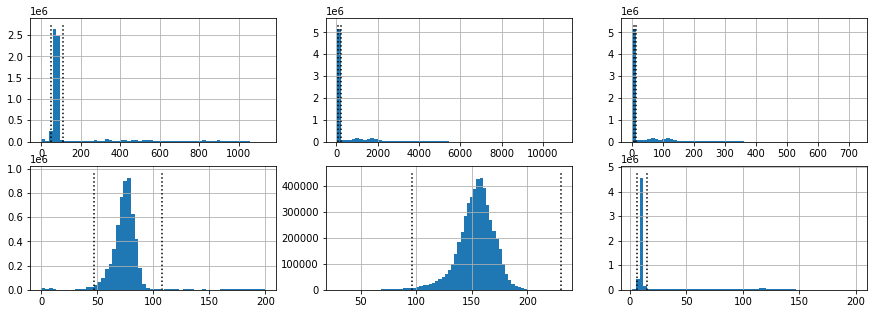

In [14]:
fig, axes = plt.subplots(2,3,figsize=(15,5))

for i, col in enumerate(['len_NT_to_TT','len_sum_of_parts', 'len_mean_of_parts']):
    hist = df_combined_test[col].hist(bins=60, ax=axes[0][i])
    hist1 = df_combined_test.loc[df_combined_test[col]<200,col].hist(bins=60, ax=axes[1][i])
    
    Q1, Q3 = df_combined_test[col].quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 1.7*IQR
    high_thresh = Q3 + 1.7*IQR
    ymin, ymax = hist.get_ylim()
    axes[0][i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='k', linestyles='dotted')
    ymin1, ymax1 = hist1.get_ylim()
    axes[1][i].vlines(x=[low_thresh, high_thresh], ymax= ymax1, ymin=ymin1, colors='k', linestyles='dotted')

In [35]:
remove_outliers(df_combined_test, 'len_NT_to_TT',[0,200])
remove_outliers(df_wo_outliers, 'len_sum_of_parts',[50,250])

In [36]:
len(df_wo_outliers.index) / len(df_combined_test.index)

0.7393736135375278

In [37]:
cols_curv = list(df_wo_outliers.filter(like='curv').columns)
cols_curv

['curv_NT',
 'curv_DH1',
 'curv_DH2',
 'curv_DNP',
 'curv_DTP1',
 'curv_DTP2',
 'curv_DTP3',
 'curv_DTP4',
 'curv_DTP5',
 'curv_DTP6',
 'curv_DTP7',
 'curv_DTP8',
 'curv_DTP9',
 'curv_DTP10',
 'curv_TT']

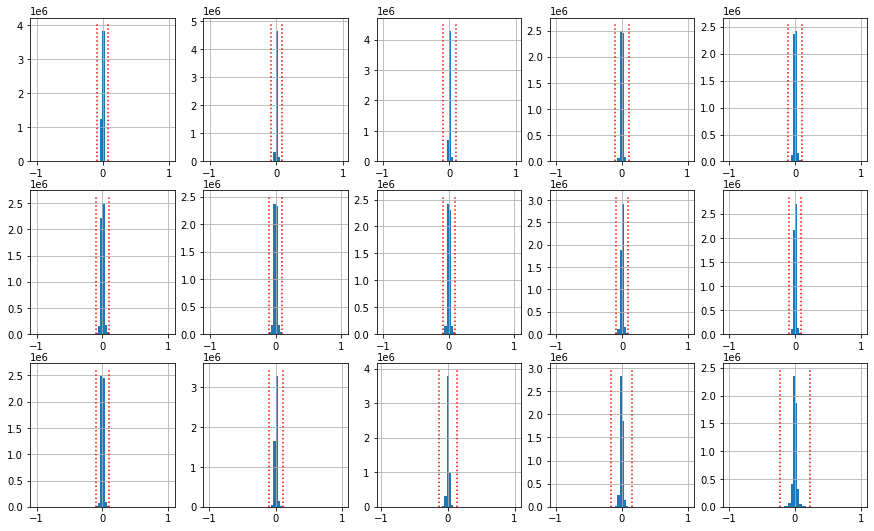

In [38]:
fig, axes = plt.subplots(3,5,figsize=(15, 9))
axes = axes.ravel()
for i, col in enumerate(cols_curv):
    hist = df_wo_outliers.loc[(df_wo_outliers[col]<1) & (df_wo_outliers[col]>-1), col].hist(ax=axes[i], bins=60)
    # .loc[(df_wo_outliers[col]<0.1) & (df_wo_outliers[col]>-0.1), col]
    
    # print(stats.shapiro(df_combined_test.loc[(df_combined_test[col]<0.1) & (df_combined_test[col]>-0.1), col]))
    Q1, Q3 = df_wo_outliers[col].quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 7*IQR
    high_thresh = Q3 + 7*IQR
    
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='r', linestyles='dotted')

In [39]:
for i, col in enumerate(cols_curv):
    remove_outliers(df_wo_outliers, col)

In [40]:
len(df_wo_outliers.index) / len(df_combined_test.index)

0.7206113117066169

In [41]:
df_combined_test.filter(like='speed').columns

Index(['speed_NT', 'speed_DH1', 'speed_DH2', 'speed_DNP', 'speed_DTP1',
       'speed_DTP2', 'speed_DTP3', 'speed_DTP4', 'speed_DTP5', 'speed_DTP6',
       'speed_DTP7', 'speed_DTP8', 'speed_DTP9', 'speed_DTP10', 'speed_TT',
       'speed_VTP10', 'speed_VTP9', 'speed_VTP8', 'speed_VTP7', 'speed_VTP6',
       'speed_VTP5', 'speed_VTP4', 'speed_VTP3', 'speed_VTP2', 'speed_VTP1',
       'speed_VNP', 'speed_MOUTH'],
      dtype='object')

In [42]:
cols_speed = list(df_combined_test.filter(regex='(^speed_N.*)|(^speed_D.*)|(^speed_V.*)|(^speed_T.*)').columns)
len(cols_speed)

26

In [ ]:
sample_curves = np.random.choice(df_combined_test.loc[df_combined_test[cols_speed].isna().sum(axis=1) == 0, cols_speed].values.ravel(), 1000, replace=False)
stats.lognorm.fit(sample_curves)

/share/python-virtual-environments/vame0_1/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/share/python-virtual-environments/vame0_1/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.007536815656254073 76.98855818268952
0.009002564300726686 69.2028708445663
0.008735631044377702 76.71878760113286
0.008071858482581917 87.50956629943096
0.007324879738553132 103.87095960670322
0.007087423728201142 104.81199024794398
0.006782057459366539 109.92097357173921
0.006158030590783657 135.52497477533845
0.00658321547165717 120.02526101482316
0.006761522350536738 116.68613510160039
0.007683099144863213 108.88375030198873
0.008278525088023958 111.72491675610536
0.007365898951689277 138.39142345721987
0.007873659959553019 155.0504770990919
0.007489556490512498 172.09221679124252
0.016972752669268495 40.72626620374881
0.016058971764639475 38.291109529246185
0.016230626844207813 36.75177029068285
0.016224895558453523 31.075291902393595
0.015451634633758891 30.433883078224284
0.015125616375725435 31.15167776672319
0.014864288250536309 33.691752658009975
0.01493936491599204 29.99514716369627
0.014889795066891755 31.629983462965004
0.015009045156627371 28.66462296661531
0.01474604547

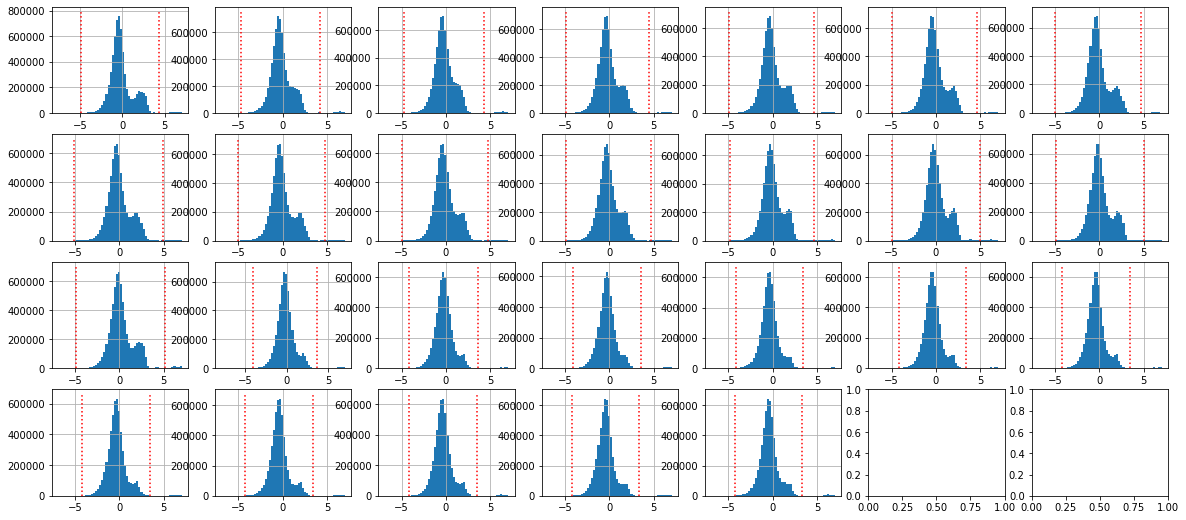

In [43]:
fig, axes = plt.subplots(4,7,figsize=(20, 9))
dict_thresh_speeds = {}
axes = axes.ravel()
df_combined_test.replace([np.inf, -np.inf], np.nan, inplace=True)

for i, col in enumerate(cols_speed):
    sel_data = df_combined_test[col]
    sel_data = sel_data[(sel_data.notna())]
    log_vals = np.log(sel_data)
    hist = log_vals[(log_vals!=np.inf)&(log_vals!=-1*np.inf)&(log_vals!=np.nan)].hist(ax =axes[i], bins=60)
    
    Q1, Q3 = log_vals.quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 3*IQR
    high_thresh = Q3 + 3*IQR

    dict_thresh_speeds[col] = [np.exp(low_thresh), np.exp(high_thresh)]

    print(np.exp(low_thresh), np.exp(high_thresh))
    
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='r', linestyles='dotted')

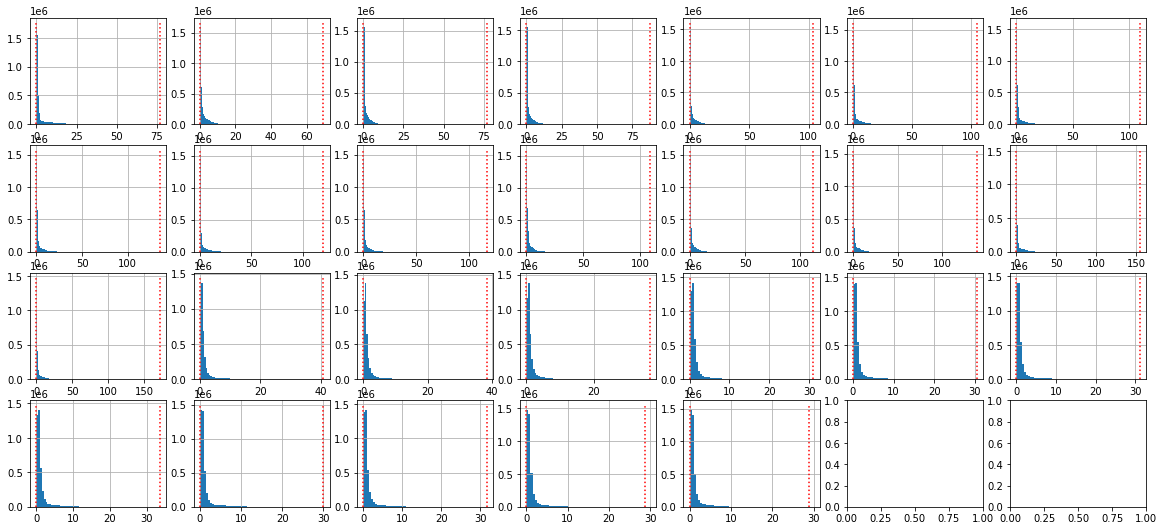

In [44]:
fig, axes = plt.subplots(4,7,figsize=(20, 9))
axes = axes.ravel()
for i, col in enumerate(cols_speed):
    hist = df_wo_outliers.loc[(df_wo_outliers[col] >= 0) & (df_wo_outliers[col] < 30), col].hist(ax=axes[i], bins=60)
    
    # print(stats.kstest(df_combined_test.loc[(df_combined_test[col]<20), col], "lognorm", stats.lognorm.fit(sample_curves)))
#     Q1, Q3 = df_wo_outliers[col].quantile([.25, .75])
#     IQR = Q3 - Q1
#     low_thresh = Q1 - 3*IQR
#     high_thresh = Q3 + 3*IQR

    low_thresh, high_thresh = dict_thresh_speeds[col]
    
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='r', linestyles='dotted')

In [45]:
for i, col in enumerate(cols_speed[:15]):
    remove_outliers(df_wo_outliers, col, dict_thresh_speeds[col])

In [46]:
for i, col in enumerate(cols_speed[15:]):
    remove_outliers(df_wo_outliers, col, dict_thresh_speeds[col])

In [47]:
(len(df_wo_outliers.index) / len(df_combined_test.index)) * 100

70.00668854170368

<AxesSubplot:>

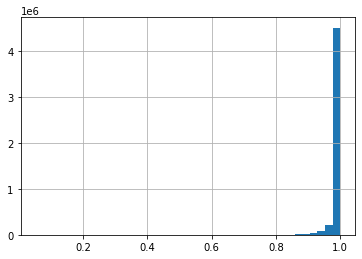

In [48]:
df_wo_outliers['quirkiness'].hist(bins=40)

In [49]:
len(df_wo_outliers.index)

4865950

In [29]:
# test_df = pd.read_hdf('../../results/pickled_featureset_v2.h5', key='features')
# len(test_df.index)

4865950

# Save

In [50]:
df_wo_outliers.to_hdf('../../results/pickled_featureset_v3.h5', key='features')